In [1]:
%load_ext autoreload

%autoreload 2

In [41]:
# ! tar -cvf cbvr.tar.gz .

## Read all videos

In [2]:
import numpy as np,pandas as pd
from collections import OrderedDict
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import all_in_one_utils as ao_util

Using TensorFlow backend.


[INFO] C3D model loaded ...


In [4]:
vid_cat = pd.read_csv('video-category.csv')
mapping = OrderedDict(zip(vid_cat.iloc[:,0],vid_cat.iloc[:,1]))

## Generate c3d encoding

In [5]:
batch_size=16
def get_3d_encoding(all_paths):
    all_ = pd.DataFrame()
    total_embeds = 0
    for idx,vid in enumerate(all_paths):   
        name = str(vid.absolute())
        vid_id = vid.stem
        num = ao_util.get_3d_feature(name,batch_size)
        feat_cols = [ 'pixel'+str(i) for i in range(num.shape[1]) ] 
        feat_data = pd.DataFrame(num,columns=feat_cols)
        feat_data['video_id'] = pd.Series(np.tile(int(vid_id),len(num)))
        feat_data['label'] = pd.Series(np.tile(mapping[int(vid_id)],len(num)))
        all_ = all_.append(feat_data,ignore_index=True)
        total_embeds+=len(num)
    assert len(all_) == total_embeds , "error in reading embeddings"
    return all_

In [6]:
generate_afresh = False

## Optional : save the above info

In [7]:
c3_encoded_data_path = (Path.home() / '.cbvr' )
c3_encoded_data_path.mkdir(parents=True, exist_ok=True)
c3_encoded_data_file = str(c3_encoded_data_path / 'c3_encoding.pkl')

In [8]:
if generate_afresh:
    video_dir = 'Videos/'
    all_paths = sorted(Path(video_dir).glob('*.mp4'))
    df = get_3d_encoding(all_paths)
    df.to_pickle(c3_encoded_data_file)
else:
    df = pd.read_pickle(c3_encoded_data_file)

In [9]:
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,video_id,label,pca-one,pca-two,pca-three
0,0.000000,0.0,0.000000,1.218057,0.0,0.0,6.574213,0.000000,0.0,0.0,...,1.132048,0.0,0.0,0.0,0.0,12069887,FUNNY,33.493016,7.100074,-5.642242
1,0.000000,0.0,1.084609,2.115129,0.0,0.0,2.295232,0.000000,0.0,0.0,...,6.698915,0.0,0.0,0.0,0.0,12069887,FUNNY,26.614904,2.632102,-4.060029
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.917292,0.000000,0.0,0.0,...,5.240896,0.0,0.0,0.0,0.0,12069887,FUNNY,20.847944,-1.839365,-6.114331
3,0.132195,0.0,3.906395,0.000000,0.0,0.0,0.000000,0.586866,0.0,0.0,...,2.319211,0.0,0.0,0.0,0.0,12069887,FUNNY,33.281023,0.585274,0.518931
4,0.000000,0.0,3.709773,0.000000,0.0,0.0,0.000000,0.138456,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,12069887,FUNNY,37.347069,1.153552,-1.343067


## mark all feature cols

In [10]:
feat_cols = df.columns[:4096]

## Visualise the encodings once

In [11]:
rndperm = np.random.permutation(df.shape[0])

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.08674966 0.04609506 0.02766516]


In [13]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two' , color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components ")


/home/deep-vision/.virtualenvs/video-works/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


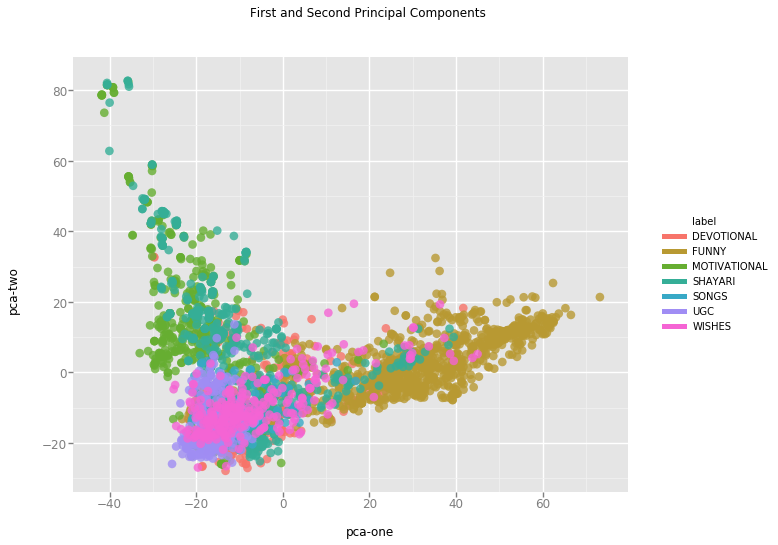

<ggplot: (8788841092872)>

In [14]:
chart

## Reduce the dimension to have 90% variance

In [15]:
vid_matrix = df[feat_cols].values

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(vid_matrix)
# Apply transform to both the training set and the test set.
scaled_vid_matrix = scaler.transform(vid_matrix)

In [17]:
pca_90 = PCA(0.95)
pca_90.fit(scaled_vid_matrix)
pca_result_90 = pca_90.transform(scaled_vid_matrix)

print ('Explained variation per principal component: {}'.format(np.sum(pca_90.explained_variance_ratio_)))

Explained variation per principal component: 0.9500413519926723


In [18]:
pca_result_90.shape

(19315, 1468)

In [19]:
pca_feat_cols = [ 'pixel'+str(i) for i in range(pca_result_90.shape[1]) ] 
pca_df = pd.DataFrame(pca_result_90,columns=pca_feat_cols)

In [20]:
pca_df[['video_id','label']] = df[['video_id','label']]

## attach the id , class and class id. 

In [21]:
X = pca_result_90
ids,text_labels = df.label.factorize()
Y = ids

In [22]:
n_classes = len(np.unique(Y))
input_dim = X.shape[1]

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook', font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from sklearn.manifold import TSNE

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", n_classes))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(n_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, text_labels[i], fontsize=14)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

# Generating and visualizing t-SNE embeddings of the raw data
# of the first 512 samples.
# tsne = TSNE()
# train_tsne_embeds = tsne.fit_transform(X)
# scatter(train_tsne_embeds, Y, "Samples from Training Data")

## Train a classifier to check accuracy

#### split the data

In [24]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_X, test_X, train_ids, test_ids = train_test_split(
    X, Y, test_size=0.1, random_state=0)

In [25]:
test_ids.shape

(1932,)

In [26]:
import all_classifiers as cls

###### logistic regression

In [27]:
logsitic_model = cls.train_and_report(train_X, train_ids,test_X,test_ids,algo_name='logistic')

0.9684265010351967


## MLP

In [33]:
mlp_model = cls.train_and_report(train_X, train_ids,test_X,test_ids,algo_name='mlp')

Epoch 1/10
17383/17383 [==============================] - 4s 239us/step - loss: 0.6005 - acc: 0.7892
Epoch 2/10
17383/17383 [==============================] - 4s 212us/step - loss: 0.2311 - acc: 0.9126
Epoch 3/10
17383/17383 [==============================] - 4s 213us/step - loss: 0.1704 - acc: 0.9315
Epoch 4/10
17383/17383 [==============================] - 4s 212us/step - loss: 0.1415 - acc: 0.9407
Epoch 5/10
17383/17383 [==============================] - 4s 213us/step - loss: 0.1243 - acc: 0.9460
Epoch 6/10
17383/17383 [==============================] - 4s 212us/step - loss: 0.1098 - acc: 0.9505
Epoch 7/10
17383/17383 [==============================] - 4s 213us/step - loss: 0.1063 - acc: 0.9520
Epoch 8/10
17383/17383 [==============================] - 4s 214us/step - loss: 0.0960 - acc: 0.9563
Epoch 9/10
17383/17383 [==============================] - 4s 214us/step - loss: 0.1003 - acc: 0.9558
Epoch 10/10
1932/1932 [==============================] - 0s 100us/step
[INFO] your final re

In [53]:
## save all pickle objects 
import pickle

def save_all_intermediates(directory):
    ## scalar
    with open(directory+"/scalar.pkl","wb") as scalar_:
        pickle.dump(scaler, scalar_)
    ## pca
    with open(directory+"/pca.pkl","wb") as pca_:
        pickle.dump(pca_90, pca_)

    # Creates a HDF5 file 'my_model.h5'
    mlp_model.save(directory+"/mlp_model.pkl")
    
     ## pca
    with open(directory+"/text_labels.pkl","wb") as text_labels_:
        pickle.dump(text_labels, text_labels_)
    
    ## features 
    with open(directory+"/pca_df.pkl","wb") as pca_df_:
        pickle.dump(pca_df, pca_df_)

save_all_intermediates("/home/deep-vision/.cbvr/persistent_files")
# ! ls -al 

In [ ]:
from keras.models import load_model
def get_all_intermediates(directory):
    mlp_model = load_model(directory+"/mlp_model.pkl")
    with open(directory+"/scalar.pkl","rb") as scalar_:
        scaler = pickle.load( scalar_)
    ## pca
    with open(directory+"/pca.pkl","rb") as pca_:
        pca_90 = pickle.load( pca_)
     ## pca
    with open(directory+"/text_labels.pkl","rb") as text_labels_:
        text_labels = pickle.load( text_labels_)
    ## features 
    with open(directory+"/pca_df.pkl","rb") as pca_df_:
        pca_df = pickle.load( pca_df_) 
    return scaler,pca_90,pca_df,mlp_model,text_labels

# Testing 

1. read the video
2. get the c3d encoding
3. PCA with train settings
5. pass through the siamese model to get the embedding
6. pass through the video classification model to get the class id
7. Load encodings for all videos corresponding the judged class id
8. Calculate distance between the query video encodings and judged video encodings
9. take top video-id for each ecoding
10. whichever video id repeats most becomes the recommended video

In [ ]:
def get_video_class(video_path):
    query_c3d = ao_util.get_3d_feature(video_path)

    scaled_query = scaler.transform(query_c3d)

    query_video_embdedding = pca_90.transform(scaled_query)

    predicted_class = mlp_model.predict_classes(query_video_embdedding,128)

    predicted_class = list(map(lambda x : text_labels[x],predicted_class))

    return query_video_embdedding,max(predicted_class,key=predicted_class.count)


In [ ]:

# 12124087 , 12099245 , 12461814 , 12459567 , 12377756
video_url = 'Videos/12099245.mp4'

from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_url))

In [ ]:
query_video_embdedding,video_class = get_video_class(video_url)

print("The video belongs from {} category".format(video_class))

video_id = int(video_url.split("/")[-1].split(".")[0])

filtered_embedding = pca_df[(pca_df['label']==video_class) & 
                            (pca_df['video_id']!=video_id)]

pixel_cols =[val for val in pca_df.columns if val.startswith('pixel')]

indexed_embedding = filtered_embedding[pixel_cols]

from scipy.spatial.distance import cdist
distance = cdist(query_video_embdedding,indexed_embedding)

n_least = 1
sorted_idx = np.argsort(distance,axis=1)[:,:n_least]

clip_to_id = np.apply_along_axis(lambda vid_id : filtered_embedding['video_id'].iloc[vid_id] , 1, sorted_idx)

from scipy import stats
repeated = stats.mode(clip_to_id)

rec_id = np.asscalar(repeated[0])
print(rec_id)

In [39]:
from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="Videos/{}.mp4" type="video/mp4">
</video>
""".format(rec_id))